In [1]:
import os
import pandas as pd
import numpy as np

# Paths to data
data_folder = r"C:\Users\sejac\Desktop\csv_labels"
top_bins_path = r"C:\Users\sejac\Desktop\top_1000_bins_u_test.csv"

# Function to calculate z-scores with special handling for zero entries
def calculate_z_scores(data):
    # Exclude zeros when calculating mean and standard deviation
    non_zero_data = data[data != 0]
    mean = non_zero_data.mean()
    std = non_zero_data.std()

    # Avoid division by zero in case all non-zero values are the same
    if std == 0:
        return np.zeros_like(data)  # Return all zeros if standard deviation is zero

    # Calculate z-scores for non-zero values
    z_scores = (data - mean) / std
    z_scores[data == 0] = 0  # Keep zeros as zero
    return z_scores

# Load top 1000 bins
top_bins = pd.read_csv(top_bins_path)['Bin_ID']

# Initialize list to store all patients' data
all_patients_data = []

# Loop through all patient files
for filename in os.listdir(data_folder):
    if filename.endswith(".csv"):
        # Determine cancer label from filename
        if "_0_" in filename:
            label = 0  # Non-cancer
        elif "_1_" in filename:
            label = 1  # Cancer
        else:
            raise ValueError(f"Unexpected filename format: {filename}")
        
        # Load patient data
        file_path = os.path.join(data_folder, filename)
        patient_data = pd.read_csv(file_path)
        
        # Create unique Bin_ID (Chromosome + Start)
        patient_data['Bin_ID'] = patient_data['Chromosome'] + ":" + patient_data['Start'].astype(str)
        
        # Filter for top bins
        patient_data = patient_data[patient_data['Bin_ID'].isin(top_bins)]
        
        # Ensure consistent data length (after filtering for top bins)
        if len(patient_data) != len(top_bins):
            print(f"Inconsistent data length for {filename}. Skipping.")
            continue
        
        # Normalize Percent_Methylation using z-scores
        normalized_methylation = calculate_z_scores(patient_data['Percent_Methylation'].values)
        patient_data['Percent_Methylation'] = normalized_methylation
        
        # Set Bin_ID as the index for easier merging later
        patient_data = patient_data.set_index('Bin_ID')['Percent_Methylation']
        
        # Add label and patient identifier
        patient_data = patient_data.to_frame(name=filename).T  # Transpose for merging
        patient_data['Label'] = label  # Add label column
        
        # Append to list
        all_patients_data.append(patient_data)

# Combine all patient data into a single DataFrame
final_data = pd.concat(all_patients_data).reset_index(drop=True)

# Extract labels
labels = final_data['Label']
features = final_data.drop('Label', axis=1)

# Fill missing values with column mean (optional, but unlikely needed after z-normalization)
features.fillna(features.mean(), inplace=True)

print("Data normalization and preparation completed.")
print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")


Data normalization and preparation completed.
Features shape: (517, 1000), Labels shape: (517,)


In [2]:
print(f"Features shape: {features.shape}")  # Should be (num_patients, 1000)
print(f"Labels shape: {labels.shape}")      # Should match the number of patients
print(f"Sample labels: {labels.head()}")    # Verify label values

Features shape: (517, 1000)
Labels shape: (517,)
Sample labels: 0    0
1    0
2    0
3    1
4    0
Name: Label, dtype: int64


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Convert features and labels to NumPy
X = features.values  # Shape: (num_patients, 1000)
y = labels.values    # Shape: (num_patients,)

# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# Define the MLP Model
class CancerClassifierMLP(nn.Module):
    def __init__(self, input_size):
        super(CancerClassifierMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [5]:
# Initialize Model, Loss, and Optimizer
input_size = X_train.shape[1]
model = CancerClassifierMLP(input_size=input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training the MLP
num_epochs = 30
patience = 5
min_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation Step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_model = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

Epoch 1/30, Train Loss: 0.7447, Val Loss: 0.6563
Epoch 2/30, Train Loss: 0.5796, Val Loss: 0.6365
Epoch 3/30, Train Loss: 0.4708, Val Loss: 0.6478
Epoch 4/30, Train Loss: 0.3548, Val Loss: 0.6926
Epoch 5/30, Train Loss: 0.2123, Val Loss: 0.7901
Epoch 6/30, Train Loss: 0.1882, Val Loss: 0.7863
Epoch 7/30, Train Loss: 0.1148, Val Loss: 0.7928
Early stopping triggered!


In [8]:
# Load the Best Model
model.load_state_dict(best_model)

# Test Evaluation
model.eval()
y_true = []
y_pred = []
y_proba = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        y_proba.extend(probs.tolist())

# Metrics
test_accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_proba)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Test Accuracy: 0.6538
ROC-AUC Score: 0.7339


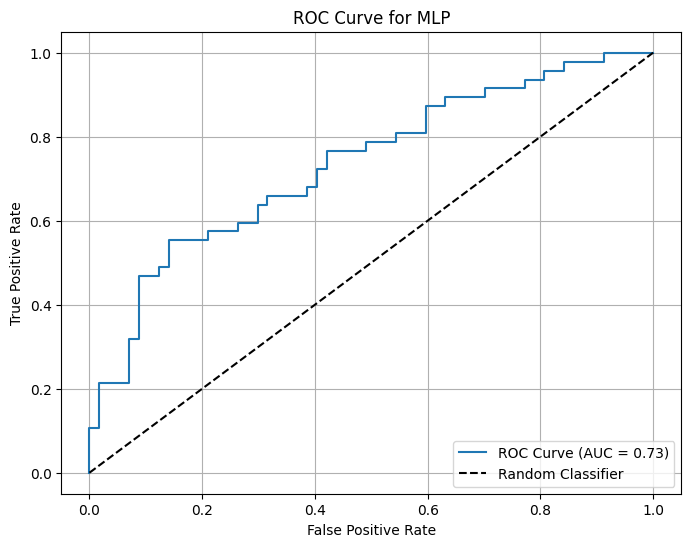

In [9]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP')
plt.legend(loc='lower right')
plt.grid()
plt.show()